# Burst Rate Calculation

In [1]:
# IMPORT FUNCTIONALITIES
import pandas as pd
import numpy as np
import scipy
from scipy.stats import chisquare
from scipy.optimize import curve_fit
from scipy.special import gamma
import matplotlib.pyplot as plt

%load_ext nb_black

<IPython.core.display.Javascript object>

Below, the file containing the candidate properties is read in and the burst times are sorted into an array. This is specified for our file structure and burst fitting procedure, and will need to be changed. <br>
We only need the MJDs for this analysis, but pandas is used so one can easily incorporate other burst properties like fluence or DM into the analysis.

In [2]:
# Read in data file
data = pd.read_csv("/home/elewis/FRB121102/all_bursts_bary.csv")
print(str(len(data)) + " total bursts")
data = data[(data["fit_method"] == "mcmc")]  # excise curvefit bursts
print(str(len(data)) + " good MCMC bursts")

# Break into individual arrays
mjd = data["$\mu_t$ (ms)"]  # burst times are given in MJD
mjd = mjd.sort_values()
DM = data["DM (pc cm$^{-3}$)"]
burst_id = data["id"]
fluence = data["$S$ (Jy ms)"]

max_diff = 7000.0  # maximum time difference between bursts, in seconds, to consider a real wait time

145 total bursts
130 good MCMC bursts


<IPython.core.display.Javascript object>

In [3]:
# SPLIT BURSTS INTO DATA FRAMES
datadict = {"MJD": mjd, "fluence": fluence}
dataframe = pd.concat(datadict, axis=1)

<IPython.core.display.Javascript object>

In [4]:
# PLOT STYLE SIZE
def set_size(width, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.
    Source: https://jwalton.info/Embed-Publication-Matplotlib-Latex/

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == "full":
        width_pt = 513.11743
    elif width == "half":
        width_pt = 242.26653
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5 ** 0.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

<IPython.core.display.Javascript object>

In [5]:
# DEFINE FITTING FUNCTIONS
# Poisson function
def poisson(x, a, r):
    return a * r * np.exp(-r * x)


# Weibull function
def weibull(x, a, k, r):
    bracket = (x * r * gamma(1 + (1 / k))) ** k
    return ((a * k) / x) * bracket * np.exp(-1.0 * bracket)


# Cumulative Poisson function
def cumul_poisson(x, r):
    return 1 - np.exp(-x * r)


# Cumulative Weibull Function
def cumul_weibull(x, k, r):
    bracket = (x * r * gamma(1 + (1 / k))) ** k
    return 1 - np.exp(-1.0 * bracket)

<IPython.core.display.Javascript object>

Below is the function that fits the Poisson and Weibull distributions to the cumulative density function. We avoid counting the difference between separate observations as a real wait time by specifying a maximum time difference to consider as real. Here, we use a constant value of 7,000 seconds derived from the length of our observations. <br>
The function assumes that the burst times are in MJD.

In [6]:
# CUMULATIVE DENSITY FUNCTION FITTING
def cumul_fit(burst_times, num_bins, min_diff, max_diff, print_flag):

    # Calculate diffs
    diffs = []
    burst_times = np.sort(burst_times)
    for i in range(0, len(burst_times) - 1):
        diff = (burst_times[i + 1] - burst_times[i]) * 86400.0
        if diff > min_diff and diff < max_diff:
            diffs.append(diff)

    # Endpoints for cumulative distribution function
    start = np.log10(np.min(diffs) * 0.5)
    end = np.log10(np.max(diffs) * 2.0)

    # Make cumulative histogram for CDF
    bins = np.logspace(start, end, num_bins)
    hist_data, bin_edges, patches = plt.hist(
        diffs, bins=bins, cumulative=True, density=True, color="w"
    )
    plt.close()

    # Get bin centers for fitting
    bin_centers = []
    for i in range(0, len(hist_data)):
        dist = bin_edges[i + 1] - bin_edges[i]
        halfdist = dist / 2.0
        mid = bin_edges[i] + halfdist
        bin_centers.append(mid)

    # Poisson fitting
    r = 0.01
    popt_poiss, pcov_poiss = curve_fit(cumul_poisson, bin_centers, hist_data, p0=[r])
    perr_poiss = np.sqrt(np.diag(pcov_poiss))

    # Weibull fitting
    k = 0.75
    r = 0.01
    popt_weib, pcov_weib = curve_fit(cumul_weibull, bin_centers, hist_data, p0=[k, r])
    perr_weib = np.sqrt(np.diag(pcov_weib))

    # Creating 'plots' of fitted Poisson/Weibull distributions
    xaxis = np.logspace(start, end, 500)
    yfit_poiss = cumul_poisson(xaxis, *popt_poiss)
    yfit_weib = cumul_weibull(xaxis, *popt_weib)

    # Variables holding rounded r and k for Poisson/Weibull distributions
    # Rate is per hour instead of per second
    r_poiss = np.round(popt_poiss[0] * 3600, 0)
    r_poiss_error = perr_poiss[0] * 3600

    k_weib = np.round(popt_weib[0], 3)
    r_weib = np.round(popt_weib[1] * 3600, 0)
    k_weib_error = np.round(perr_weib[0], 3)
    r_weib_error = perr_weib[1] * 3600

    # Calculate and pass fit statistics
    bin_centers = np.array(bin_centers)
    ss_tot = np.sum((hist_data - np.mean(hist_data)) ** 2)

    poiss_yvals = cumul_poisson(bin_centers, *popt_poiss)
    resid_poiss = abs(hist_data - poiss_yvals)
    resid_poiss_ss = np.sum(resid_poiss ** 2)

    weib_yvals = cumul_weibull(bin_centers, *popt_weib)
    resid_weib = abs(hist_data - weib_yvals)
    resid_weib_ss = np.sum(resid_weib ** 2)

    datafreqs = hist_data * len(burst_times)
    all_poiss_freqs = poiss_yvals * len(burst_times)
    all_weib_freqs = weib_yvals * len(burst_times)

    dof = len(datafreqs) - 1  # degrees of freedom
    # Poisson chi^2
    poiss_chisq, poiss_pval = scipy.stats.chisquare(datafreqs, all_poiss_freqs)
    poiss_red_chisq = poiss_chisq / (
        dof - 1
    )  # one fitted parameter for Poisson distribution
    # Weibull chi^2
    weib_chisq, weib_pval = scipy.stats.chisquare(datafreqs, all_weib_freqs)
    weib_red_chisq = weib_chisq / (
        dof - 2
    )  # two fitted parameters for Weibull distribution

    # Poisson r^2
    poiss_rsq = np.round(1 - (resid_poiss_ss / ss_tot), 3)
    # Weibull r^2
    weib_rsq = np.round(1 - (resid_weib_ss / ss_tot), 3)

    if print_flag == True:
        print("Minimum wait time= " + str(np.round(np.min(diffs), 4)) + " s")
        print("Maximum wait time= " + str(np.round(np.max(diffs), 1)) + " s")

        print("Poisson:")
        print(
            " r = "
            + str(int(r_poiss))
            + " +/- "
            + str(np.round(r_poiss_error, 1))
            + " hour^-1"
        )

        print("Weibull:")
        print(
            " r = "
            + str(int(r_weib))
            + " +/- "
            + str(np.round(r_weib_error, 1))
            + " hour^-1"
        )
        print(" k = " + str(k_weib) + " +/- " + str(k_weib_error))

        print("Poisson:")
        print(
            "Reduced Chi-squared = "
            + str(np.round(poiss_red_chisq, 3))
            + "; p-value = "
            + str(np.round(poiss_pval, 5))
            + ";  r^2 = "
            + str(poiss_rsq)
        )
        print(
            "Max resid = "
            + str(np.round(np.max(resid_poiss), 3))
            + "; avg resid = "
            + str(np.round(np.average(resid_poiss), 3))
        )

        print("Weibull:")
        print(
            "Reduced Chi-squared = "
            + str(np.round(weib_red_chisq, 3))
            + "; p-value = "
            + str(np.round(weib_pval, 5))
            + ";  r^2 = "
            + str(weib_rsq)
        )
        print(
            "Max resid = "
            + str(np.round(np.max(resid_weib), 3))
            + "; avg resid = "
            + str(np.round(np.average(resid_weib), 3))
        )

    param_array = np.array(
        [
            r_poiss,
            r_poiss_error,
            r_weib,
            r_weib_error,
            k_weib,
            k_weib_error,
            poiss_red_chisq,
            weib_red_chisq,
            poiss_pval,
            weib_pval,
        ]
    )

    return hist_data, bin_centers, diffs, xaxis, yfit_poiss, yfit_weib, param_array

<IPython.core.display.Javascript object>

In [7]:
# Fitting all wait times (above 0.1 ms- counts burst components as individual bursts)
burst_times_all = mjd
num_bins = 20
hist_data, bin_centers, diffs, xaxis, yfit_poiss, yfit_weib, param_array = cumul_fit(
    burst_times_all, num_bins, 0.0001, max_diff, True
)

r_poiss = param_array[0]
r_poiss_error = param_array[1]
r_weib = param_array[2]
r_weib_error = param_array[3]
k_weib = param_array[4]
k_weib_error = param_array[5]
poiss_chisq = param_array[6]
weib_chisq = param_array[7]
poiss_pval = param_array[8]
weib_pval = param_array[9]

Minimum wait time= 0.0019 s
Maximum wait time= 572.3 s
Poisson:
 r = 65 +/- 8.4 hour^-1
Weibull:
 r = 42 +/- 9.0 hour^-1
 k = 0.634 +/- 0.067
Poisson:
Reduced Chi-squared = 495.007; p-value = 0.0;  r^2 = 0.953
Max resid = 0.132; avg resid = 0.059
Weibull:
Reduced Chi-squared = 27.551; p-value = 0.0;  r^2 = 0.97
Max resid = 0.096; avg resid = 0.048


<IPython.core.display.Javascript object>

In [8]:
# Wait times > 1s only
(
    hist_data_2,
    bin_centers_2,
    diffs_2,
    xaxis_2,
    yfit_poiss_2,
    yfit_weib_2,
    param_array_2,
) = cumul_fit(burst_times_all, num_bins, 1.0, max_diff, True)

r_poiss_2 = param_array_2[0]
r_poiss_error_2 = param_array_2[1]
r_weib_2 = param_array_2[2]
r_weib_error_2 = param_array_2[3]
k_weib_2 = param_array_2[4]
k_weib_error_2 = param_array_2[5]
poiss_chisq_2 = param_array[6]
poiss_chisq_2 = param_array[7]
poiss_pval_2 = param_array_2[8]
weib_pval_2 = param_array_2[9]

Minimum wait time= 2.0718 s
Maximum wait time= 572.3 s
Poisson:
 r = 41 +/- 1.6 hour^-1
Weibull:
 r = 46 +/- 1.5 hour^-1
 k = 1.162 +/- 0.043
Poisson:
Reduced Chi-squared = 1.076; p-value = 0.43619;  r^2 = 0.994
Max resid = 0.056; avg resid = 0.025
Weibull:
Reduced Chi-squared = 0.368; p-value = 0.99664;  r^2 = 0.997
Max resid = 0.056; avg resid = 0.017


<IPython.core.display.Javascript object>

Below we run the same analysis for a variety of minimum wait time cutoffs. It plots the fitted values and their errors for a variety of cutoffs, and at the very bottom the final plot is created.

In [9]:
# Min and max wait times to use as cutoffs
start = np.log10(0.001)
end = np.log10(1.0)
cutoffs = np.logspace(start, end, 50)

all_rp = []
all_rpe = []
all_rw = []
all_rwe = []
all_kw = []
all_kwe = []
all_chisqp = []
all_chisqw = []
all_pvalp = []
all_pvalw = []

for cutoff in cutoffs:
    (
        hist_data_3,
        bin_edges_3,
        diffs_3,
        xaxis_3,
        yfit_poiss_3,
        yfit_weib_3,
        param_array_3,
    ) = cumul_fit(burst_times_all, num_bins, cutoff, max_diff, False)

    r_poiss_3 = param_array_3[0]
    r_poiss_error_3 = param_array_3[1]
    r_weib_3 = param_array_3[2]
    r_weib_error_3 = param_array_3[3]
    k_weib_3 = param_array_3[4]
    k_weib_error_3 = param_array_3[5]
    poiss_chisq_3 = param_array_3[6]
    weib_chisq_3 = param_array_3[7]
    poiss_pval_3 = param_array_3[8]
    weib_pval_3 = param_array_3[9]

    all_rp.append(r_poiss_3)
    all_rpe.append(r_poiss_error_3)
    all_rw.append(r_weib_3)
    all_rwe.append(r_weib_error_3)
    all_kw.append(k_weib_3)
    all_kwe.append(k_weib_error_3)
    all_chisqp.append(poiss_chisq_3)
    all_chisqw.append(weib_chisq_3)
    all_pvalp.append(poiss_pval_3)
    all_pvalw.append(weib_pval_3)

<IPython.core.display.Javascript object>

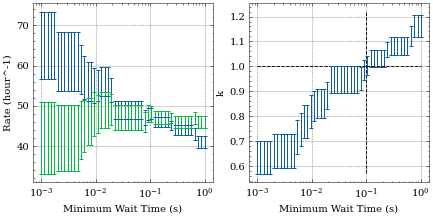

<IPython.core.display.Javascript object>

In [12]:
with plt.style.context(["science", "grid", "no-latex"]):
    fig, ax = plt.subplots(1, 2, figsize=set_size(width="full", subplots=(1.5, 2)))
    ax[0].set_xscale("log")
    ax[0].errorbar(
        cutoffs, all_rp, yerr=all_rpe, capsize=2, linestyle="", label="Poisson r"
    )
    ax[0].errorbar(
        cutoffs, all_rw, yerr=all_rwe, capsize=2, linestyle="", label="Weibull r"
    )
    # ax[0].legend(fontsize=14)
    ax[0].set_xlabel("Minimum Wait Time (s)")
    ax[0].set_ylabel("Rate (hour^-1)")

    ax[1].set_xscale("log")
    ax[1].set_xlabel("Minimum Wait Time (s)")
    ax[1].set_ylabel("k")
    ax[1].errorbar(
        cutoffs, all_kw, yerr=all_kwe, capsize=2, linestyle="", label="Weibull k"
    )
    ax[1].vlines(
        0.1,
        0.9 * np.amin(all_kw),
        1.05 * np.amax(all_kw),
        colors="k",
        linestyles="dashed",
        linewidth=0.9,
    )
    ax[1].hlines(1.0, 0.001, 1.0, colors="k", linestyles="dashed", linewidth=0.9)
    plt.show()

In [11]:
with plt.style.context(["science", "grid"]):  # , "no-latex"]):
    fig, ax = plt.subplots(1, 3, figsize=set_size(width="full", subplots=(1.25, 3)))
    ax[0].plot(
        xaxis,
        yfit_poiss,
        label=r"$r$=" + str(int(r_poiss)) + r" hr$^{-1}$",
    )
    ax[0].plot(
        xaxis,
        yfit_weib,
        "--",
        label=r"$k=$" + str(k_weib) + ",$r=$" + str(int(r_weib)) + r" hr$^{-1}$",
    )
    ax[0].plot(bin_centers, hist_data, "k.")
    ax[0].set_xscale("log")
    ax[0].set_xlabel("Wait time (s)")
    ax[0].set_ylabel("Normalized Counts")
    # ax[0].legend()

    ax[1].plot(
        xaxis_2,
        yfit_poiss_2,
        label=r"$r=$" + str(int(r_poiss_2)) + r"hr$^{-1}$",
    )
    ax[1].plot(
        xaxis_2,
        yfit_weib_2,
        "--",
        label=r"$k=$" + str(k_weib_2) + ",$r=$" + str(int(r_weib_2)) + r" hr$^{-1}$",
    )
    ax[1].plot(bin_centers_2, hist_data_2, "k.")
    ax[1].set_xscale("log")
    ax[1].set_xlabel("Wait time (s)")
    ax[1].set_ylabel("Normalized Counts")
    # ax[1].legend()

    ax[2].set_xscale("log")
    # ax[2].set_yscale("log")
    ax[2].plot(cutoffs, all_chisqp, label="Poisson")
    ax[2].plot(cutoffs, all_chisqw, "--", label="Weibull")
    # ax[2].legend()
    ax[2].set_xlabel("Minimum wait time (s)")
    ax[2].set_ylabel(r"$\chi^2$")
    plt.tight_layout()
    plt.savefig("burst_rate.pdf", bbox_inches="tight", dpi=300)
    plt.show()

RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full report generated by latex:
This is pdfTeXk, Version 3.141592-1.40.3 (Web2C 7.5.6)
 %&-line parsing enabled.
entering extended mode
(/home/elewis/.cache/matplotlib/tex.cache/9a9941363900849bf4a11d578a4291c3.tex
LaTeX2e <2005/12/01>
Babel <v3.8h> and hyphenation patterns for english, usenglishmax, dumylang, noh
yphenation, arabic, basque, bulgarian, coptic, welsh, czech, slovak, german, ng
erman, danish, esperanto, spanish, catalan, galician, estonian, farsi, finnish,
 french, greek, monogreek, ancientgreek, croatian, hungarian, interlingua, ibyc
us, indonesian, icelandic, italian, latin, mongolian, dutch, norsk, polish, por
tuguese, pinyin, romanian, russian, slovenian, uppersorbian, serbian, swedish, 
turkish, ukenglish, ukrainian, loaded.
(/usr/share/texmf/tex/latex/base/article.cls
Document Class: article 2005/09/16 v1.4f Standard LaTeX document class
(/usr/share/texmf/tex/latex/base/size10.clo))
(/usr/share/texmf/tex/latex/type1cm/type1cm.sty)

! LaTeX Error: File `type1ec.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.6 \usepackage
               {type1ec}^^M
No pages of output.
Transcript written on 9a9941363900849bf4a11d578a4291c3.log.




RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full report generated by latex:
This is pdfTeXk, Version 3.141592-1.40.3 (Web2C 7.5.6)
 %&-line parsing enabled.
entering extended mode
(/home/elewis/.cache/matplotlib/tex.cache/1acea6f6c115d0ec7a634ed0529287b9.tex
LaTeX2e <2005/12/01>
Babel <v3.8h> and hyphenation patterns for english, usenglishmax, dumylang, noh
yphenation, arabic, basque, bulgarian, coptic, welsh, czech, slovak, german, ng
erman, danish, esperanto, spanish, catalan, galician, estonian, farsi, finnish,
 french, greek, monogreek, ancientgreek, croatian, hungarian, interlingua, ibyc
us, indonesian, icelandic, italian, latin, mongolian, dutch, norsk, polish, por
tuguese, pinyin, romanian, russian, slovenian, uppersorbian, serbian, swedish, 
turkish, ukenglish, ukrainian, loaded.
(/usr/share/texmf/tex/latex/base/article.cls
Document Class: article 2005/09/16 v1.4f Standard LaTeX document class
(/usr/share/texmf/tex/latex/base/size10.clo))
(/usr/share/texmf/tex/latex/type1cm/type1cm.sty)

! LaTeX Error: File `type1ec.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.6 \usepackage
               {type1ec}^^M
No pages of output.
Transcript written on 1acea6f6c115d0ec7a634ed0529287b9.log.




<Figure size 511.2x131.641 with 3 Axes>

<IPython.core.display.Javascript object>